In [3]:
# Workable code for Repeated Data
import logging 
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

%matplotlib inline

mpl.rc('figure', figsize=(10,5))
mpl.rc('image', cmap='gray')


from pims import TiffStack

In [2]:
from __future__ import division, unicode_literals, print_function
from settings2_tp import *

### Import MultiImage Tiff file

In [33]:
newdata='/Volumes/MINI-DRIVE/Microchannel_Flow_Data/Flow_Behavior_Analysis/20180603/Data_208_x+0mm_FeNGO-Roses_C2e-1mg_mL_Q_5e-4ml_min_Z70/Data208_processed_BG_271.tif'

In [34]:
frames = TiffStack(filename=newdata)

In [35]:
path=os.path.dirname(newdata)#Used to Save Files in appropriate location
path

'/Volumes/MINI-DRIVE/Microchannel_Flow_Data/Flow_Behavior_Analysis/20180603/Data_208_x+0mm_FeNGO-Roses_C2e-1mg_mL_Q_5e-4ml_min_Z70'

In [36]:
frames

<Frames>
Source: /Volumes/MINI-DRIVE/Microchannel_Flow_Data/Flow_Behavior_Analysis/20180603/Data_208_x+0mm_FeNGO-Roses_C2e-1mg_mL_Q_5e-4ml_min_Z70/Data208_processed_BG_271.tif
Length: 10000 frames
Frame Shape: (512, 512)
Pixel Datatype: uint8

### TP Algorithm

## Choose the settings from Single Image Analysis before proceeding

In [37]:
tp_data = os.path.join(path,'data_frames.h5')# Change to path
tp_data

'/Volumes/MINI-DRIVE/Microchannel_Flow_Data/Flow_Behavior_Analysis/20180603/Data_208_x+0mm_FeNGO-Roses_C2e-1mg_mL_Q_5e-4ml_min_Z70/data_frames.h5'

In [38]:
if os.path.isfile(tp_data):print('Warning!!!: \nData overwrite possible \nWarning!!!:') 

In [14]:
print(frames,file=open(logpath,'w'))

## Run this ONLY once

In [39]:
# Only first 1000 frames
with tp.PandasHDFStore(tp_data) as s:
    tp.batch(frames[:1000],39,invert=False, minmass=8000,percentile=64, 
              preprocess=True, separation=20,
             noise_size=1, smoothing_size=None, threshold=50,
              topn=15, max_iterations=10, output=s,)

Frame 999: 1 features


## Link TP Data

In [14]:
print(frames,file=open(logpath,'w'))

In [14]:
print(frames,file=open(logpath,'w'))

In [40]:
#t = tp.link_df(f,50,memory=10)
with tp.PandasHDFStore(tp_data) as sp:
    for linked in tp.link_df_iter(sp,[20,50],memory=50):
        sp.put(linked)

Frame 999: 1 trajectories present.


In [41]:
with tp.PandasHDFStore(tp_data) as sp:
    trajectories_tp = pd.concat(iter(sp))

In [42]:
refer=962
trajectories_tp[trajectories_tp['frame']==refer]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
7,149.565017,76.613280,16789.102657,5.355173,0.386460,188.011997,77319.0,0.463730,962,103
9,189.997546,214.312432,8113.270635,4.303729,0.110205,132.714351,62440.0,0.806946,962,104
10,238.678023,325.014637,20300.134533,5.328445,0.052513,174.003260,78316.0,0.450880,962,100
13,337.220746,379.445400,14151.773589,4.776477,0.270712,150.409597,73975.0,0.512743,962,101
16,364.965345,199.656068,30679.134055,12.907024,0.309589,89.213536,238372.0,0.082753,962,98
19,379.082783,282.675301,20636.344222,6.680841,0.247331,164.418334,114316.0,0.225376,962,92


## Compare Trajectory Output

In [65]:
# Ignore Trajectories shorter than 9 frames
t1=tp.filter_stubs(trajectories_hough,3)
print('Hough Trajectories')
print('Before:', trajectories_hough['particle'].nunique())
print('After:', t1['particle'].nunique())

Hough Trajectories
Before: 2789
After: 1809


In [43]:
t2=tp.filter_stubs(trajectories_tp,3)
print('TP Trajectories')
print('Before:', trajectories_tp['particle'].nunique())
print('After:', t2['particle'].nunique())

TP Trajectories
Before: 119
After: 91


In [25]:
plt.figure()
tp.annotate(t1_2[t1_2['frame'] == refer], frames[refer]);

NameError: name 't1_2' is not defined

<Figure size 720x360 with 0 Axes>

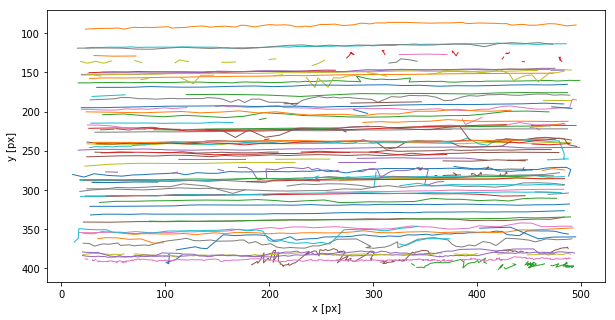

In [44]:
trj1, trax1 = plt.subplots()
#tp.plot_traj(t1)
tp.plot_traj(t2);
#trj.savefig('1_3157_lessthan 9 frame trajectories.jpg')
plt.close()

In [46]:
particle_density = pd.DataFrame(t2[['particle','x','y']])
grouped = particle_density.groupby(['particle'])
#agg = grouped.aggregate(np.mean)
agg = grouped.aggregate(np.median)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c230f7f98>,
      dtype=object)

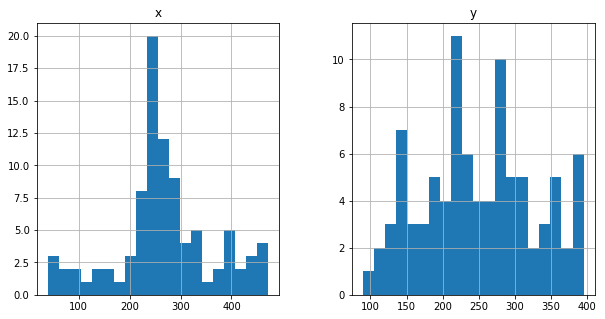

In [48]:
agg.hist(bins=20)

## Run this ONLY once

In [52]:
with tp.PandasHDFStore(hough_data) as ts:
    frame_results = ts.get(25)
    
frame_results.head()

,x,y,size,hough_signal,frame,ecc
0,230,56,15,0.477273,25,0
1,260,417,15,0.454545,25,0
2,390,469,15,0.420455,25,0
3,53,173,16,0.416667,25,0
4,428,484,15,0.409091,25,0


In [5]:
def new_estimate_mass(dfrow_input,*args):
    "Compute the total brightness in the neighborhood of a local maximum."
    dfrow = dfrow_input.astype(int)
    #print("Integer:",dfrow)
    cx =dfrow['x']
    cy= dfrow['y']
    radius=dfrow['size']
    frame=dfrow['frame']
    #print('cx,cy,rad,frame:',cx,cy,radius,frame)# = dfrow.values
    image=frames[frame]
    try:
        neighborhood = tp.masks.binary_mask(radius, image.ndim)
        imsub=image[slice(cy-radius,cy+radius+1),slice(cx-radius,cx+radius+1)]
        #print('check')
        ng= neighborhood*imsub
        return np.sum(ng)#/255
    except:
        logger.debug('Mass Estimation Error:')
        logger.debug('cx,cy,rad,frame:',cx,cy,radius,frame)
        image = pad(image,2*radius,'minimum')
        neighborhood = tp.masks.binary_mask(radius, image.ndim)
        imsub=image[slice(cy-radius,cy+radius+1),slice(cx-radius,cx+radius+1)]
        #print('check')
        ng= neighborhood*imsub
    return np.sum(ng)#/255

## Link Hough Data

 ## Merge Datasets

In [ ]:
combined_data = os.path.join(path,'combined_data.h5')

In [ ]:
if os.path.isfile(combined_data):print('Warning!!!: \nData overwrite possible \nWarning!!!:') 

In [ ]:
#for frameno in np.arange(len(frames)):
for frameno in np.arange(len(frames)):
    #print('Frame No: ',frameno)
    #if frameno > 3:
    #   break

    #frameno=1990

    try:
        #Calling Blue
        with tp.PandasHDFStore(hough_data) as ts:
            hough_frame = ts.get(frameno)
            Blue=1
    except:
        logger.debug('No Hough Circles found in Frame #:',frameno)
        Blue=0
    try:
        #Calling Red
        with tp.PandasHDFStore(tp_data) as ts2:
            tp_frame = ts2.get(frameno)
            Red=1
    except:
        logger.debug('No TP particles found in Frame #:',frameno)
        Red=0
   
    if Red==0 & Blue==0:
        continue
    elif Red==0 & Blue==1:
        combined_frame=hough_frame
    elif Red==1 & Blue==0:
        combined_frame=tp_frame
    elif Red==1 & Blue==1:
        try:
            tpset = pd.DataFrame(tp_frame[['y','x','size','frame']])
            htset = pd.DataFrame(hough_frame[['y','x','size','frame']])

            tree=spatial.KDTree(tp_frame[['y','x']])
            hough_frame[['keep_hough','remove_tp_index','distance']]=htset.iloc[:,:].apply(find_nearest,axis=1)
            hough_frame=hough_frame[hough_frame.keep_hough == 1]
            remove_tp = [val for val in hough_frame.remove_tp_index if (val >=0 and val <100) ]
            remove_tp=np.array(remove_tp).astype(int)
            tp_frame = tp_frame.drop(tp_frame.index[remove_tp])
            hough_frame=hough_frame.drop(columns=['remove_tp_index','keep_hough','distance'])
            combined_frame = pd.concat([tp_frame,hough_frame],ignore_index=True)
        except:
            logger.info("Error in Analysing Frame:",frameno)
            try:
                print('Attempting Merge of Default values..Frame No. :',frameno)
                combined_frame = pd.concat([tp_frame,hough_frame],ignore_index=True)
                print('success')
            except:
                print('Unsuccessful. Moving to next frame:')
                continue
       
   
        
    
    with tp.PandasHDFStore(combined_data) as tc:
            tc.put(combined_frame)
    

In [ ]:
 with tp.PandasHDFStore(combined_data) as tc:
        w = tc.get(3455)

In [ ]:
w

## link again

In [ ]:
#t = tp.link_df(f,5,memory=3)
with tp.PandasHDFStore(combined_data) as sp:
    for linked in tp.link_df_iter(sp,50,memory=10):
        sp.put(linked)

In [406]:
with tp.PandasHDFStore(combined_data) as sp:
    trajectories_cmb = pd.concat(iter(s))

NameError: name 'combined_data' is not defined

In [ ]:
trajectories_cmb[trajectories_cmb['frame']==refer]

In [ ]:
t4=tp.filter_stubs(trajectories_cmb,9)
print('Before:', trajectories_cmb['particle'].nunique())
print('After:', t2['particle'].nunique())

In [ ]:
plt.figure()
tp.annotate(t4[t4['frame'] == refer], frames[refer]);


In [ ]:
trj, trax = plt.subplots()
tp.plot_traj(t4);
save_file=os.path.join(path,'trajectories.jpg')
trj.savefig(save_file)
plt.close()

In [51]:
# Plot the numbers vs pixels

In [89]:
#Remove short trajectories
t2=tp.filter_stubs(trajectories_tp,5)
print('Before:', trajectories_tp['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 286
After: 137


In [399]:
particle_density = pd.DataFrame(t2_smooth[['particle','x','y']])

In [400]:
particle_density.head()

,particle,x,y
0,0,NaN,NaN
1,0,NaN,NaN
2,0,NaN,NaN
3,0,NaN,NaN
4,0,NaN,NaN


In [401]:
grouped = particle_density.groupby(['particle'])

In [402]:
#agg = grouped.aggregate(np.mean)
agg = grouped.aggregate(np.median)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28f441d0>,
      dtype=object)

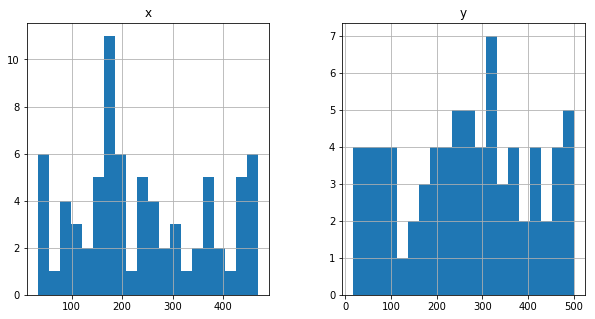

In [403]:
agg.hist(bins=20)

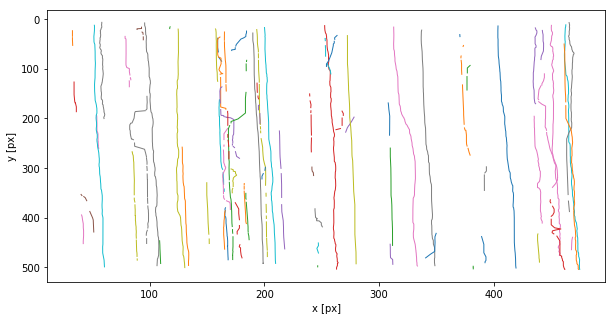

In [405]:
tp.plot_traj(t2_smooth)

In [35]:
frames

<Frames>
Source: /Volumes/MINI-DRIVE/Microchannel_Flow_Data/Flow_Behavior_Analysis/1mmwidthMC_center_FeNGOroses_2e-2mg_mL_5e-4mL_min/Result*.tif
Length: 1618 frames
Frame Shape: (512, 512)
Pixel Datatype: uint8

(array([5., 3., 4., 2., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([  5.     ,  19.21875,  33.4375 ,  47.65625,  61.875  ,  76.09375,
         90.3125 , 104.53125, 118.75   , 132.96875, 147.1875 , 161.40625,
        175.625  , 189.84375, 204.0625 , 218.28125, 232.5    , 246.71875,
        260.9375 , 275.15625, 289.375  , 303.59375, 317.8125 , 332.03125,
        346.25   , 360.46875, 374.6875 , 388.90625, 403.125  , 417.34375,
        431.5625 , 445.78125, 460.     ]),
 <a list of 32 Patch objects>)

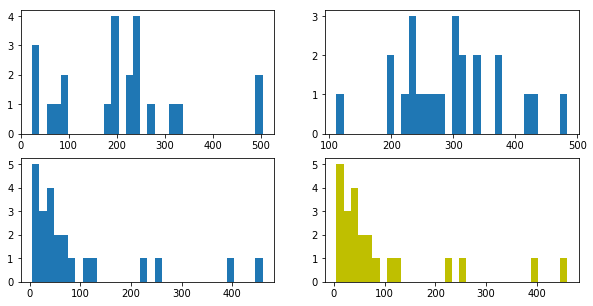

In [36]:
fig, ax = plt.subplots(2,2)
agg = grouped.aggregate(np.median)
ax[0,0].hist(agg.x,bins=32)
ax[0,1].hist(agg.y,bins=32)
agg2= grouped.count()
ax[1,0].hist(agg2.x,bins=32)
ax[1,1].hist(agg2.y,bins=32,color='y')


In [251]:
# Calculate angles

In [254]:
tp.motion.direction_corr?

Signature: tp.motion.direction_corr(t, frame1, frame2)
Docstring:
Compute the cosine between every pair of particles' displacements.

Parameters
----------
t : DataFrame
    trajectories, containing columns particle, frame, x, and y
frame1 : frame number
frame2 : frame number

Returns
-------
DataFrame, indexed by particle, including dx, dy, and direction
File:      ~/anaconda/envs/softmatter/lib/python3.6/site-packages/trackpy/motion.py
Type:      function


In [275]:
tp.motion.msd?

Signature: tp.motion.msd(traj, mpp, fps, max_lagtime=100, detail=False, pos_columns=None)
Docstring:
Compute the mean displacement and mean squared displacement of one
trajectory over a range of time intervals.

Parameters
----------
traj : DataFrame with one trajectory, including columns frame, x, and y
mpp : microns per pixel
fps : frames per second
max_lagtime : intervals of frames out to which MSD is computed
    Default: 100
detail : See below. Default False.

Returns
-------
DataFrame([<x>, <y>, <x^2>, <y^2>, msd], index=t)

If detail is True, the DataFrame also contains a column N,
the estimated number of statistically independent measurements
that comprise the result at each lagtime.

Notes
-----
Input units are pixels and frames. Output units are microns and seconds.

See also
--------
imsd() and emsd()
File:      ~/anaconda/envs/softmatter/lib/python3.6/site-packages/trackpy/motion.py
Type:      function


In [277]:
t2.particle.unique()

array([ 0,  1,  3,  6,  7,  8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 31, 32])

In [278]:
tsp1=t2[t2.particle==3]

In [279]:
mean_sq_dist = motion.msd(tsp1, mpp=0.8,fps=100/3, max_lagtime=3000)

In [272]:
mean_sq_dist

,<x>,<y>,<x^2>,<y^2>,msd,lagt
lagt,,,,,,
1,0.130013,3.738201,0.097986,17.168066,17.266052,0.03
2,0.249329,7.491804,0.206636,65.270599,65.477235,0.06
3,0.364419,11.260988,0.362502,143.934356,144.296858,0.09
4,0.469631,15.024973,0.519193,251.551396,252.070589,0.12
5,0.562740,18.783525,0.674792,389.191213,389.866005,0.15
6,0.646603,22.561119,0.816270,556.352627,557.168897,0.18
7,0.740140,26.370348,0.956895,754.400670,755.357566,0.21
8,0.831964,30.201429,1.099433,982.066287,983.165720,0.24
9,0.928471,34.068423,1.215293,1242.138080,1243.353373,0.27


In [280]:
tp.motion.direction_corr?

Signature: tp.motion.direction_corr(t, frame1, frame2)
Docstring:
Compute the cosine between every pair of particles' displacements.

Parameters
----------
t : DataFrame
    trajectories, containing columns particle, frame, x, and y
frame1 : frame number
frame2 : frame number

Returns
-------
DataFrame, indexed by particle, including dx, dy, and direction
File:      ~/anaconda/envs/softmatter/lib/python3.6/site-packages/trackpy/motion.py
Type:      function


In [283]:
tp.direction_corr?

Signature: tp.direction_corr(t, frame1, frame2)
Docstring:
Compute the cosine between every pair of particles' displacements.

Parameters
----------
t : DataFrame
    trajectories, containing columns particle, frame, x, and y
frame1 : frame number
frame2 : frame number

Returns
-------
DataFrame, indexed by particle, including dx, dy, and direction
File:      ~/anaconda/envs/softmatter/lib/python3.6/site-packages/trackpy/motion.py
Type:      function


In [291]:
type(tsp1)

pandas.core.frame.DataFrame

In [297]:
np.arctan2(tsp1.x[0],tsp1.y[-1])*180/np.pi

frame
85     51.193179
86     50.008428
90     44.073650
91     42.883807
93     41.181188
94     40.886757
95     39.604517
96     38.636643
101    34.901738
Name: x, dtype: float64

In [17]:
t2.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
count,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000
mean,257.923328,277.777119,1793.033746,2.354995,0.154093,100.003851,5217.547468,0.002092,1827.923038,54.148481
std,147.862138,155.943807,860.221078,0.393152,0.141151,50.566476,2441.705040,0.003961,933.042455,34.098739
min,3.643357,31.406902,500.398006,1.768175,0.001210,14.739342,1265.000000,0.000000,0.000000,0.000000
25%,128.909158,124.822435,952.295728,1.998489,0.059155,40.789325,3381.000000,0.000000,1076.000000,33.000000
50%,259.001534,261.292319,1814.041326,2.227196,0.095281,114.642253,4876.000000,0.000000,1699.000000,47.000000
75%,385.495007,452.428956,2354.965313,2.730663,0.180931,145.060976,6595.000000,0.003515,2635.000000,79.000000
max,506.458908,475.365527,4428.871837,3.346033,0.593417,173.813491,17020.000000,0.043735,3714.000000,117.000000


In [39]:
t2.groupby('particle').filter(lambda x: tp.diagonal_size(x) > 100).describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
count,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000
mean,265.959114,300.433922,1895.122679,2.322984,0.126939,105.377440,5501.303658,0.001972,1752.430817,50.199844
std,144.257555,151.207032,844.100986,0.369819,0.118325,48.080834,2456.378588,0.003679,866.219915,31.251952
min,3.643357,32.383345,500.879153,1.768175,0.001210,14.739342,1426.000000,0.000000,0.000000,1.000000
25%,141.110110,132.166489,1176.830690,1.995106,0.055120,56.746704,3691.000000,0.000000,1037.000000,26.000000
50%,275.590480,313.509663,1922.941033,2.204091,0.085363,119.069173,5172.000000,0.000000,1662.000000,43.000000
75%,386.434510,457.336304,2440.951981,2.648849,0.139460,146.926425,6872.000000,0.003424,2578.000000,79.000000
max,506.458908,475.365527,4428.871837,3.346033,0.563408,172.954530,17020.000000,0.043735,3457.000000,116.000000


In [365]:
t2_dist.describe()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
count,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000
mean,257.923328,277.777119,1793.033746,2.354995,0.154093,100.003851,5217.547468,0.002092,1827.923038,54.148481
std,147.862138,155.943807,860.221078,0.393152,0.141151,50.566476,2441.705040,0.003961,933.042455,34.098739
min,3.643357,31.406902,500.398006,1.768175,0.001210,14.739342,1265.000000,0.000000,0.000000,0.000000
25%,128.909158,124.822435,952.295728,1.998489,0.059155,40.789325,3381.000000,0.000000,1076.000000,33.000000
50%,259.001534,261.292319,1814.041326,2.227196,0.095281,114.642253,4876.000000,0.000000,1699.000000,47.000000
75%,385.495007,452.428956,2354.965313,2.730663,0.180931,145.060976,6595.000000,0.003515,2635.000000,79.000000
max,506.458908,475.365527,4428.871837,3.346033,0.593417,173.813491,17020.000000,0.043735,3714.000000,117.000000


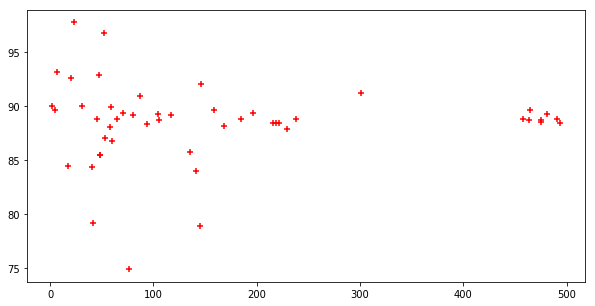

In [380]:

t2_traj_info['angle'] = pd.DataFrame(t2_smooth.groupby('particle').agg(smoothened_single_traj_angle).x)

t2_traj_info['length'] = pd.DataFrame(t2_smooth.groupby('particle').agg(tp.diagonal_size).x)

plt.scatter(t2_traj_info.length,t2_traj_info.angle,marker='+',color='r')

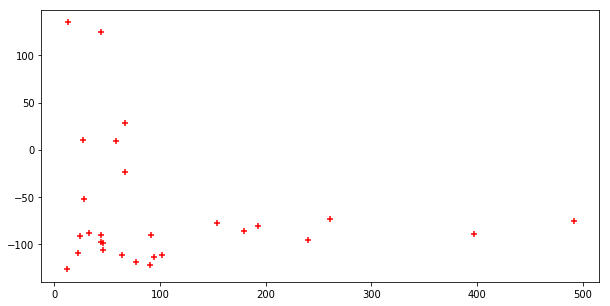

In [475]:

t2_traj_info['angle'] = pd.DataFrame(t2.groupby('particle').agg(smoothened_single_traj_angle).x)

t2_traj_info['length'] = pd.DataFrame(t2.groupby('particle').agg(tp.diagonal_size).x)

plt.scatter(t2_traj_info.length,t2_traj_info.angle,marker='+',color='r')

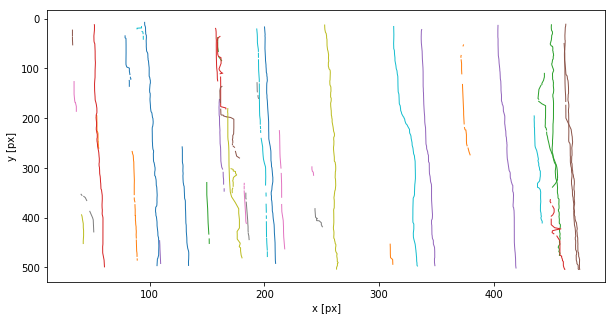

In [394]:
tp.plot_traj(t2_smooth.groupby('particle').filter(lambda x: single_traj_angle(x) < 89))# and tp.diagonal_size(x)>100))

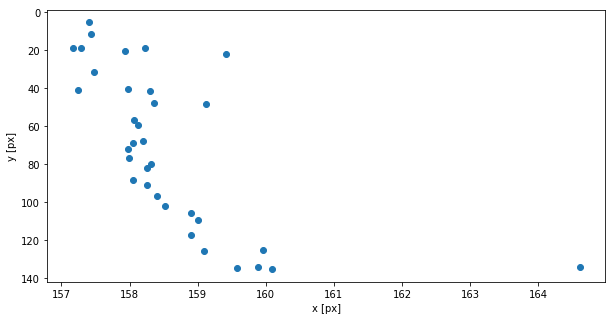

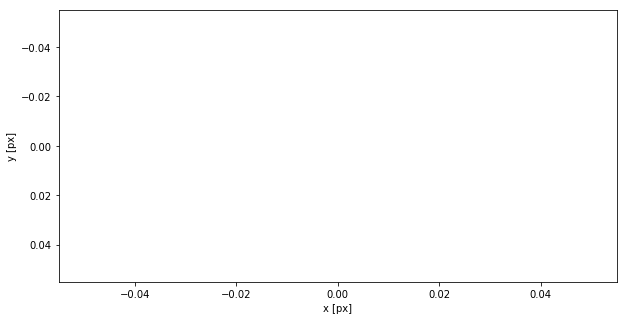

In [312]:
tp.plots.scatter(post2)
tp.plots.scatter(pos)

In [136]:
smoothened_single_traj_angle(tx)

85.53079316334993

In [138]:
single_traj_angle(tx)

74.5891607654782

In [92]:
t2_smooth=trajectories_tp.groupby('particle').apply(median_smooth_trajectory)

NameError: name 'median_smooth_trajectory' is not defined

In [378]:
t2_smooth = t2_smooth.reset_index(drop=True)

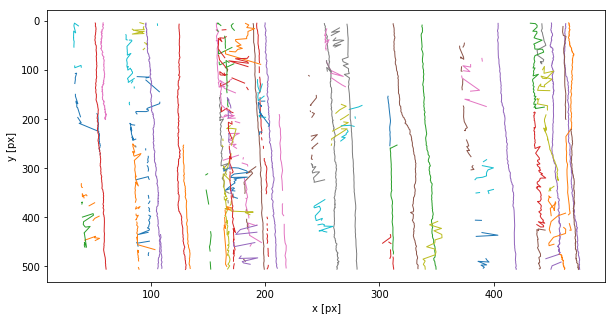

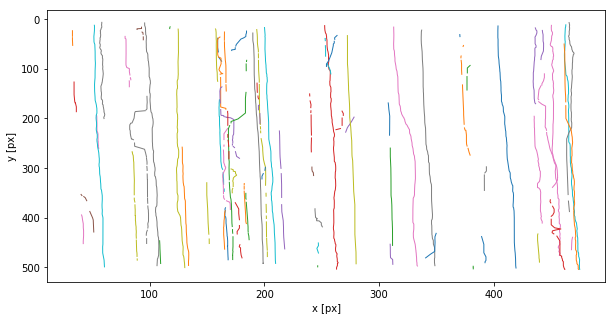

In [379]:
tp.plot_traj(t2)#.groupby('particle').filter(lambda x: single_traj_angle(x) > 70 and tp.diagonal_size(x)>100))
tp.plot_traj(t2_smooth)#.groupby('particle').filter(lambda x: single_traj_angle(x) > 70 and tp.diagonal_size(x)>100))

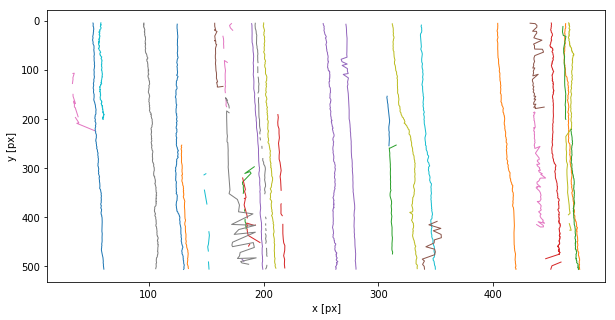

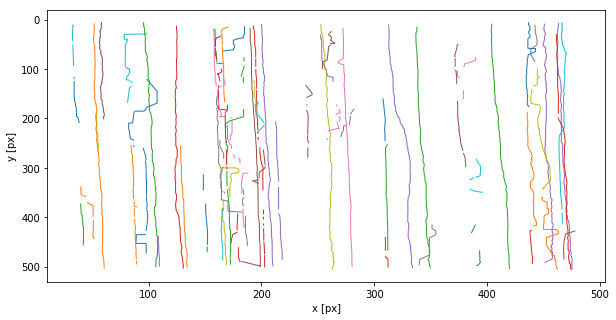

In [375]:
tp.plot_traj(t2.groupby('particle').filter(lambda x: single_traj_angle(x) > 70 and tp.diagonal_size(x)>100))
tp.plot_traj(t2_smooth.groupby('particle').filter(lambda x: single_traj_angle(x) > 70 and tp.diagonal_size(x)>50))

In [ ]:
# Just plot Velocity and Brightness as a function of x,y grid and then sum as trajectories??